<a href="https://colab.research.google.com/github/arturtoshev/SciML22-23/blob/master/exercise/2_BayesianInference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2. Bayesian Linear and Logistic Regression

**Software**

Similar to the `torch.nn` module in PyTorch containing the most frequently used neural network building blocks, there are also tools for Bayesian inference tasks. In this class we will use the universal probabilistic programming language (PPL) [Pyro](https://pyro.ai/) which is supported by PyTorch on the backend (The correspondint tool in TensorFlow is [TensorFlow Probability](https://www.tensorflow.org/probability)). At its core these probabilistic programming systems construct a domain-specific language to express express probabilistic models, sample from probability distributions and utilize their integrated inference engines such as `Hamiltonian Monte-Carlo`, `Sequential Monte-Carlo`, `Variational Inference`, etc. hence making it much easier for us to express probabilistic control-flows, as well as representing uncertainties in our algorithms.

In [ ]:
!pip3 install pyro-ppl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd

# visualization libraries
from matplotlib import pyplot as plt
import seaborn as sns
import arviz as az

# PyTorch
import torch
from torch.autograd import Variable

# Pyro
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, init_to_mean
# SVI and Trace_ELBO below are related to Variational Inference, which you are 
# not expected to understand yet.
from pyro.infer import SVI, Trace_ELBO, Predictive, MCMC, NUTS


In [ ]:
# visualization utilities
plt.rcParams['font.size'] = '16'

def plot_training_curve(loss_vec):
  fig = plt.figure(figsize=(10,6))
  plt.plot(np.arange(len(loss_vec)) + 1, loss_vec)
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.yscale("log")
  plt.title("Training curve")
  plt.grid()

## 2.1 Bayesian Linear Regression

### Problem setting
- Given: given is a set of measurement pairs $\left\{x^{(i)}, y^{\text {(i)}}\right\}_{i=1,...m}$ with $x \in \mathbb{R}^{n}$ and $y \in \mathbb{R}$
- Question:  if a give you a novel $x$, what would be your best guess about its corresponding $y$ **and how certain are you about it**?
- Linear regression assumption: 
 $$y \approx h(x) = wx + b + \epsilon$$

Where we have moved to the more common weights $w = [\vartheta_1, ..., \vartheta_n]$ and bias $b=\vartheta_0$ notation. Other than the change of notation, the only difference up until now is the random noise term $\epsilon$, which can, in general, originate from any probability distribution. The difference to the maximul likelihood interpretation on the normal linear regression we discussed in [Exercise 1](https://github.com/arturtoshev/SciML_22-23/blob/master/1_linReg_logReg.ipynb), is that here we allow for any distribution in contrast to restricting ourselves to the Gaussian.

The other novel part is that in the Bayesian setting the parameters of the model ($w, b$) are random variables with some prior distribution.

**References**

This part is mainly based on [this](https://pyro.ai/examples/bayesian_regression.html) Pyro tutorial and [this](https://github.com/csiro-mlai/hackfest-ppl/blob/c5bb342cdae3cf325ae39a226ce89e43a530b04a/primitives/05-regression_with_data.ipynb) further code. 



### 2.1.1 Artificial Dataset

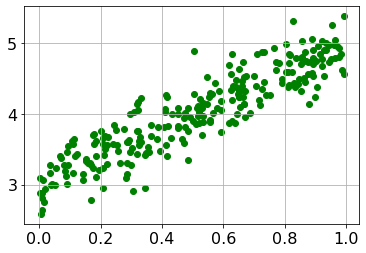

In [ ]:
# See Exercise 1 for more details on this dataset
a = 3 # bias
b = 2 # weight
x = np.random.rand(256)

noise = np.random.randn(256) / 4

y = a + b*x + noise

plt.scatter(x, y, color='green')
plt.grid()
plt.show()

# Reshape the input variables for training
x_train = Variable(torch.from_numpy(x.reshape(-1, 1).astype('float32')))
y_train = Variable(torch.from_numpy(y.astype('float32')))


### 2.1.2 Non-Bayesian (Classical) Linear Regression (revised)

Parameter initialization:
weight :  tensor([[0.1425]])
bias :  tensor([0.1731])
Learned parameters:
weight [[1.9420254]]
bias [3.0249953]


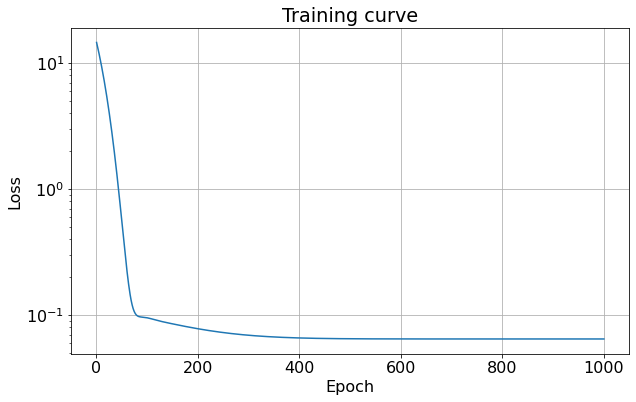

In [ ]:
# Regression model
linear_reg_model = PyroModule[torch.nn.Linear](1, 1)

print("Parameter initialization:")
for name, param in linear_reg_model.named_parameters():
  print(name, ": ", param.data)

# Define loss and optimize
loss_fn = torch.nn.MSELoss()
optim = torch.optim.Adam(linear_reg_model.parameters(), lr=0.05)
num_iterations = 1000

loss_vec = np.zeros((num_iterations,))
for j in range(num_iterations):
    # run the model forward on the data
    y_pred = linear_reg_model(x_train).squeeze(-1)
    # calculate the mse loss
    loss = loss_fn(y_pred, y_train)
    # initialize gradients to zero - has to be done before the .backward step
    optim.zero_grad()
    # backpropagate
    loss.backward()
    # take a gradient step
    optim.step()

    loss_vec[j] = loss.item()

plot_training_curve(loss_vec)

# Inspect learned parameters
print("Learned parameters:")
for name, param in linear_reg_model.named_parameters():
    print(name, param.data.numpy())

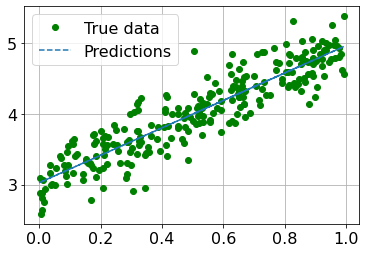

In [ ]:
with torch.no_grad():
    predicted = linear_reg_model(x_train).data.numpy()

plt.clf()
plt.plot(x_train, y_train, 'go', label='True data')
plt.plot(x_train, predicted, '--', label='Predictions')
plt.legend()
plt.grid()
plt.show()

### 2.1.3 Bayesian Linear Regression Model

And now we seek to express our Bayesian linear regression model. For a detailed explanation of the terms of this model, see [this](https://pyro.ai/examples/bayesian_regression.html#Model) example. What you should know is that there are three different pieces of `model()` which are encoded via the mapping:
1. Observations $\Longleftrightarrow$ `pyro.sample` with the `obs` argument.
2. Latent random variables $\Longleftrightarrow$ `pyro.sample`.
3. Parameters $\Longleftrightarrow$ `pyro.param`.

The model below essentially makes the following prior assumptions:

\begin{align}
y_i &\sim \mathcal{N}(\mu, \sigma)\\
\mu &= w \cdot x_i + b\\
w &\sim \mathcal{N}(0,1)\\
b &\sim \mathcal{N}(0,10)\\
\sigma &\sim U(0,1)\\
\end{align}


In [ ]:
class BayesianLinearRegression(PyroModule):

    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = PyroModule[torch.nn.Linear](input_dim, output_dim)
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([output_dim, input_dim]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([output_dim]).to_event(1))
    
    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

model = BayesianLinearRegression(1, 1)

### 2.1.4 MCMC: Sampling and Inference



In the lecture we saw different Monte Carlo sampling strategies, e.g. Acceptance-Rejection Sampling and Adaptive Rejection Sampling, but the default sampler in Pyro are different. There are multiple reasons for that, some of which include:
- in the Acceptance-Rejection approaches, we need to know the constant $M$, which we often don't a-priori know
- we could use the gradient information of the likelihood surface to find regions with higher probability faster
- often we are happy if we know an approximation of the pdf, especially if computing this quantity is very fast, which is why Variational Inference approaches are so popular.

Here, we will see how to use the two most practically relevant approaches, namely Markov Chain Monte Carlo (MCMC) and Stochastic Variational Inference (SVI). We start with MCMC.

The No U-turn Sampler (NUTS, for more information see [The No-U-turn sampler: Adaptively setting path lengths in Hamiltonian Monte Carlo](https://arxiv.org/abs/1111.4246) by Hoffmann & Gelman, 2014) is a gradient-based MCMC approach. Starting from an initial point it generates a trajectory in the domain space such that the frequency of being in a given region is guaranteed to be proportional to the probability density of that region. For a visual of the NUTS walk see [this](http://chi-feng.github.io/mcmc-demo/app.html?algorithm=NaiveNUTS&target=banana) website. 


In [ ]:
# Sampling

nuts_kernel = NUTS(model, adapt_step_size=True)
mcmc = MCMC(nuts_kernel, num_samples=3000, warmup_steps=1000)
mcmc.run(x_train, y_train)

Sample: 100%|██████████| 4000/4000 [02:18, 28.97it/s, step size=3.07e-01, acc. prob=0.941]


In [ ]:
mcmc_samples = mcmc.get_samples()

for k in mcmc_samples.keys():
  s = torch.squeeze(mcmc_samples[k])
  print(f"{k} = {torch.mean(s).item():.3f} +/- {torch.std(s).item():.3f}")


linear.bias = 3.029 +/- 0.033
linear.weight = 1.935 +/- 0.055
sigma = 0.256 +/- 0.011


In [ ]:
for k in mcmc_samples.keys():
  print(k, torch.squeeze(mcmc_samples[k]).shape)

linear.bias torch.Size([3000])
linear.weight torch.Size([3000])
sigma torch.Size([3000])


In [ ]:
def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats

# Inference

predictive = Predictive(model, mcmc_samples,
                        return_sites=("linear.weight", "obs", "_RETURN"))
samples = predictive(x_train)
pred_summary = summary(samples)

mu = pred_summary["_RETURN"]
y = pred_summary["obs"]
predictions = pd.DataFrame({
    "x": x_train[:, 0],
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "y_true": y_train,
})
predictions = predictions.sort_values(by=["x"])

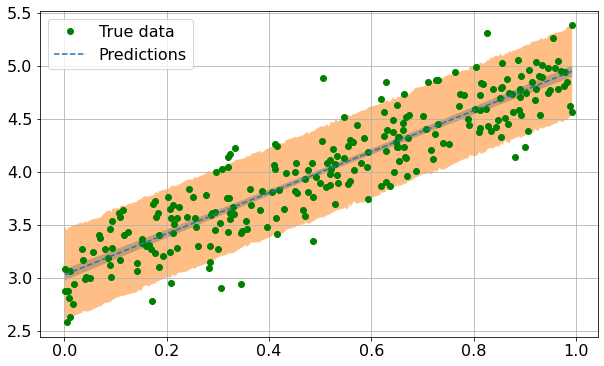

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.plot(x_train, y_train, 'go', label='True data')
plt.plot(predictions["x"], predictions["mu_mean"], '--', label='Predictions')
plt.fill_between(predictions["x"],
                 predictions["mu_perc_5"],
                 predictions["mu_perc_95"],
                 alpha=0.5)
plt.fill_between(predictions["x"],
                 predictions["y_perc_5"],
                 predictions["y_perc_95"],
                 alpha=0.5)
plt.legend()
plt.grid()
plt.show()

### 2.1.5 SVI: Training, Sampling and Inference

An alternative to MCMC (and the default method in Pyro) is Variational Inference (VI). At this point in time you are not expected to know how variational inference works. Just remember that MCMC directly gives us samples from the posterior distribution, whereas VI first fits a surrogate posterior pdf and later samples from it as much as we want.

This is how you would construct a training loop with Stochastic VI (yes, VI first trains a posterior pdf surrogate and then samples from it).

AutoDiagonalNormal.loc Parameter containing:
tensor([-3.6453,  1.9169,  3.0175])
AutoDiagonalNormal.scale tensor([0.0471, 0.0270, 0.0162])


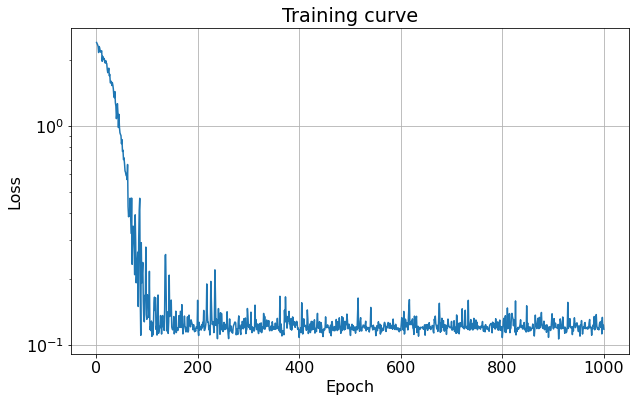

In [ ]:
# Training

guide = AutoDiagonalNormal(model)
adam = pyro.optim.Adam({"lr": 0.03})
# Stochastic Variational Inference (SVI) does the heavy-lifting for us.
# We give it 1. a model, 2. a guide that models the distribution of unobserver 
# parameters, 3. an optimization routine used to fit parameters, and 4. a loss.
svi = SVI(model, guide, adam, loss=Trace_ELBO())

pyro.clear_param_store()
loss_vec = np.zeros((num_iterations,))
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_train, y_train)
    loss_vec[j] = loss / len(x_train)
  
plot_training_curve(loss_vec)

guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

Given a trained model, how to make predictions using it?

In [ ]:
# Sampling

predictive = Predictive(model, guide=guide, num_samples=800,
                        return_sites=("linear.weight", "obs", "_RETURN"))

# Inference

samples = predictive(x_train)
pred_summary = summary(samples)

mu = pred_summary["_RETURN"]
y = pred_summary["obs"]
predictions = pd.DataFrame({
    "x": x_train[:, 0],
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "y_true": y_train,
})
predictions = predictions.sort_values(by=["x"])


[Text(0, 0.5, 'y'),
 Text(0.5, 0, 'x'),
 Text(0.5, 1.0, 'Bayesian Linear Regression')]

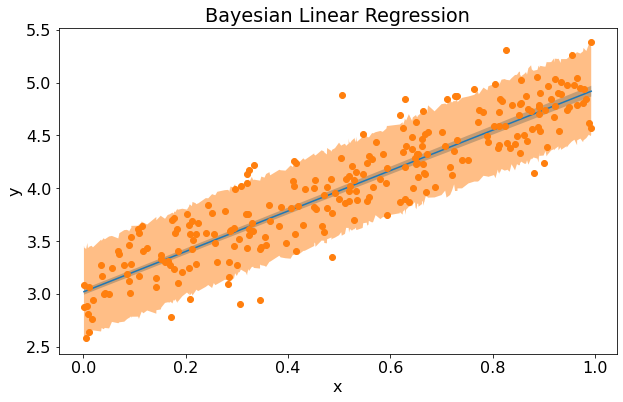

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey=True)

ax.plot(predictions["x"],
        predictions["mu_mean"])
ax.fill_between(predictions["x"],
                predictions["mu_perc_5"],
                predictions["mu_perc_95"],
                alpha=0.5)
ax.fill_between(predictions["x"],
                predictions["y_perc_5"],
                predictions["y_perc_95"],
                alpha=0.5)
ax.plot(predictions["x"],
        predictions["y_true"],
        "o")
ax.set(xlabel="x",
      ylabel="y",
      title="Bayesian Linear Regression")


We now need to (automatically) find the best distribution for our model and perform inference over our regression algorithm to learn the posterior distribution over our unobserved parameters.

### 2.1.6 Exercise
Apply Bayesian Linear Regression with the Terrain Ruggedness vs GDP dataset from [this](https://pyro.ai/examples/bayesian_regression.html) Pyro tutorial.

In [ ]:
####################
# TODO


####################

## 2.2 Bayesian Logistic Regression

### 2.2.1 Iris Dataset (revised)

In [ ]:
from sklearn.datasets import load_iris

X_df, y = load_iris(as_frame=True, return_X_y=True)

target_names = ['setosa', 'versicolor', 'virginica']
# standardize X
X_df.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
X = X_df.apply(lambda x: (x - x.mean())/x.std(), axis=0)
X.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

X['iris_type'] = y
X['is_setosa'] = np.where(X['iris_type'].values == 0, 1,0)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   iris_type     150 non-null    int64  
 5   is_setosa     150 non-null    int64  
dtypes: float64(4), int64(2)
memory usage: 7.2 KB


In [ ]:
X.head()

,sepal_length,sepal_width,petal_length,petal_width,iris_type,is_setosa
0,-0.897674,1.015602,-1.335752,-1.311052,0,1
1,-1.139200,-0.131539,-1.335752,-1.311052,0,1
2,-1.380727,0.327318,-1.392399,-1.311052,0,1
3,-1.501490,0.097889,-1.279104,-1.311052,0,1
4,-1.018437,1.245030,-1.335752,-1.311052,0,1


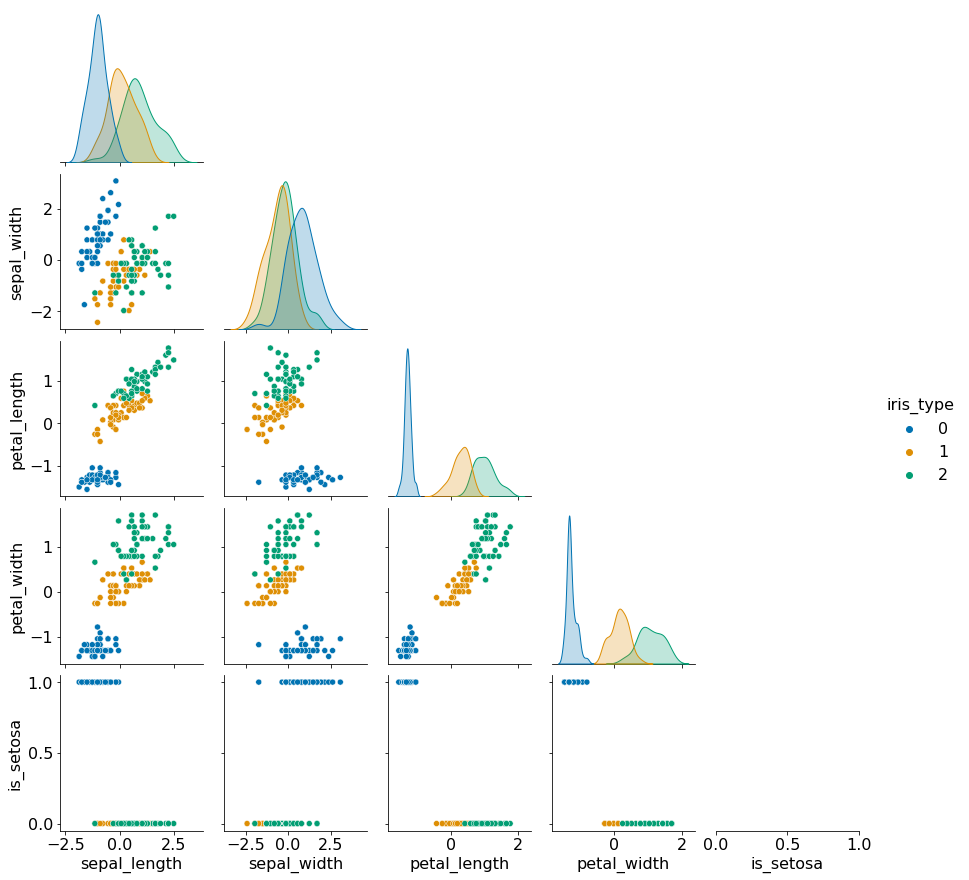

In [ ]:
sns.pairplot(data=X, hue='iris_type', palette="colorblind", corner=True); #setosa is easy to distinguish, versicolor and virginica are harder


In [ ]:
data = torch.tensor(X[['petal_width']].values, dtype=torch.float)
target = torch.tensor(X['is_setosa'].values, dtype=torch.float)

### 2.2.2 Bayesian Logistic Regression Model

Taks:
- Given "petal_width", determine whether the class is "setosa".

The tools used here are the same as for the Bayesian Linear Regression task, thus we omit lengthy explanations. Reach out to us if something is unclear!

> Hint: You might consider [this](https://github.com/seanreed1111/colab-demos/blob/8fa0713b2fb0fd9018de9de89593cc427d6b08d2/old/pyro_logistic_regression_iris.ipynb) useful.


In [ ]:
class BayesianLogisticRegression(PyroModule):
    def __init__(self, in_features, out_features = 1, bias = True):
        super().__init__()
        self.linear = PyroModule[torch.nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(-35., 5.).expand([out_features, in_features]).to_event(2))
        if bias:
          self.linear.bias = PyroSample(dist.Uniform(-25., 5.).expand([out_features]).to_event(1))
        
    def forward(self, x, y=None):
        logits = self.linear(x).squeeze(-1)

        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Bernoulli(logits=logits), obs=y)
        return logits

### 2.2.3 Using SVI

In [ ]:
model = BayesianLogisticRegression(data.size(1))
guide = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)

def train(model, guide, lr=0.01, n_steps=2000):
    pyro.set_rng_seed(1)
    pyro.clear_param_store()
    
    gamma = 0.01  # final learning rate will be gamma * initial_lr
    lrd = gamma ** (1 / n_steps)
    adam = pyro.optim.ClippedAdam({'lr': lr, 'lrd': lrd})

    svi = SVI(model, guide, adam, loss=Trace_ELBO())

    for i in range(n_steps):
        elbo = svi.step(data, target)
        if i % 500 == 0:
          print(f"Elbo loss: {elbo}")

In [ ]:
%%time
train(model, guide)

Elbo loss: 9.350290536880493
Elbo loss: 2.805009201169014
Elbo loss: 1.4718698005599435
Elbo loss: 1.9484067456796765
CPU times: user 9.37 s, sys: 28.9 ms, total: 9.4 s
Wall time: 9.42 s


In [ ]:
num_samples = 1000
predictive = Predictive(model, guide=guide, num_samples=num_samples)

svi_samples = {k: v.reshape((num_samples,-1)).detach().cpu().numpy()
               for k, v in predictive(data, target).items()
               if k != "obs"}

In [ ]:
for k in svi_samples.keys():
  print(k, svi_samples[k].mean())


linear.weight -34.34986
linear.bias -16.362192


In [ ]:
guide.quantiles([0.05,0.50,0.95])


{'linear.weight': tensor([[[-37.1637]],
 
         [[-34.3472]],
 
         [[-31.5306]]]), 'linear.bias': tensor([[-20.3906],
         [-16.5955],
         [-11.3549]])}

In [ ]:
svi_samples['linear.weight'].mean(axis=0)


array([-34.34986], dtype=float32)

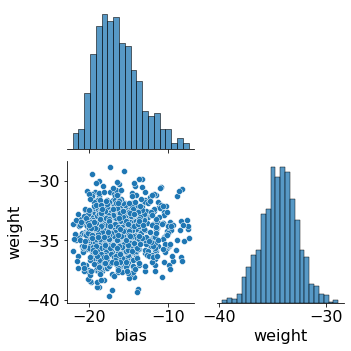

In [ ]:
samples = pd.DataFrame({'bias':svi_samples['linear.bias'].squeeze(), 'weight':svi_samples['linear.weight'].squeeze()})
sns.pairplot(data=samples, corner=True);

### 2.2.4 Using MCMC

In [ ]:
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=3000, warmup_steps=1000)

In [ ]:
%%time
mcmc.run(data, target)

Sample: 100%|██████████| 4000/4000 [01:17, 51.84it/s, step size=3.79e-01, acc. prob=0.854]

CPU times: user 1min 16s, sys: 576 ms, total: 1min 16s
Wall time: 1min 17s


In [ ]:
hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}


In [ ]:
for k in hmc_samples.keys():
  print(k, np.mean(hmc_samples[k]))


linear.bias -17.743967
linear.weight -34.775425


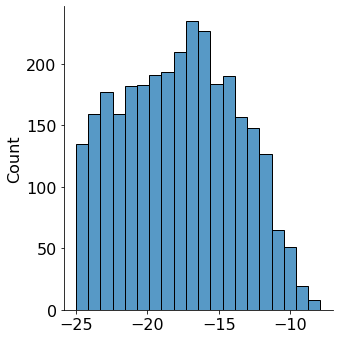

In [ ]:
sns.displot(hmc_samples['linear.bias'][:,0])

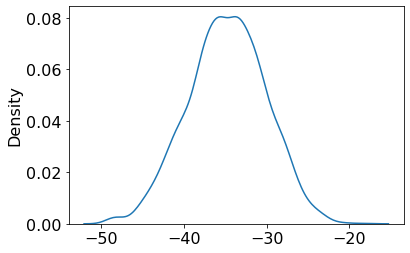

In [ ]:
sns.kdeplot(hmc_samples['linear.weight'][:,0,0]);


### 2.2.5 Exercise

Apply Bayesian logistic regression using all existing inputs:

`iris_type ~ sepal_length + sepal_width + petal_length + petal_w`

> Hint: Look at [this](https://github.com/seanreed1111/colab-demos/blob/8fa0713b2fb0fd9018de9de89593cc427d6b08d2/old/pyro_logistic_regression_iris.ipynb) code for help.

In [ ]:
####################
# TODO


####################